In [1]:
# import libraries
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the dataset
n_samples = 10000
n_features = 10

X_raw, y_raw = make_classification(n_samples=10000, n_features=10, n_informative=7, n_redundant=0, n_repeated=0, random_state=0, 
                                   n_classes=2, weights=[0.9, 0.1], shuffle=False)

n_samples, n_features = X_raw.shape
print('No. samples = ', n_samples)
print('No. features = ', n_features)

No. samples =  10000
No. features =  10


In [3]:
# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.33, random_state=0)

# scale train dataset
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# scale test dataset
X_test_scaled = scaler.transform(X_test)

In [4]:
# train logistic regression & cross validation
clf_L2 = LogisticRegressionCV(Cs=100, cv=10, penalty='l2', random_state=0, multi_class='multinomial', solver='lbfgs', n_jobs=-1)
clf_L2.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='multinomial', n_jobs=-1,
                     penalty='l2', random_state=0, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [5]:
# Compute ROC curve and ROC area for each class
LR_y_score = clf_L2.predict_proba(X_test_scaled)[:,1]
LR_fpr, LR_tpr, LR_thresholds = roc_curve(y_test, LR_y_score)
LR_roc_auc = auc(LR_fpr, LR_tpr)
print('LR AUC = ', LR_roc_auc)

LR AUC =  0.7635294117647058


In [6]:
# train Random Forest
clf_RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf_RF.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [7]:
# Compute ROC curve and ROC area for each class
RF_y_score = clf_RF.predict_proba(X_test_scaled)[:,1]
RF_fpr, RF_tpr, RF_thresholds = roc_curve(y_test, RF_y_score)
RF_roc_auc = auc(RF_fpr, RF_tpr)
print('RF AUC = ', RF_roc_auc)

RF AUC =  0.9190217607313196


In [8]:
import xgboost as xgb 
xg_trn_data = xgb.DMatrix(X_train, label=y_train)
xg_vld_data = xgb.DMatrix(X_test, label=y_test)

num_round = 50
xgb_param = {"objective": "binary:logitraw" ,
            "eval_metric": "auc",
            'eta': 0.4, 'booster': 'gbtree', 'max_depth': 3}
watchlist = [(xg_trn_data, "train"), (xg_vld_data, "valid")]

bst = xgb.train(xgb_param, xg_trn_data, num_round, watchlist)
XG_y = bst.predict(xgb.DMatrix(X_test), ntree_limit=bst.best_iteration+1)
  
XG_fpr, XG_tpr, _ = roc_curve(y_test, XG_y)
XG_roc_auc = auc(XG_fpr, XG_tpr)

[0]	train-auc:0.79978	valid-auc:0.77215
[1]	train-auc:0.86495	valid-auc:0.84832
[2]	train-auc:0.90573	valid-auc:0.87332
[3]	train-auc:0.91144	valid-auc:0.87406
[4]	train-auc:0.92061	valid-auc:0.88487
[5]	train-auc:0.92977	valid-auc:0.88989
[6]	train-auc:0.93080	valid-auc:0.89098
[7]	train-auc:0.93441	valid-auc:0.89310
[8]	train-auc:0.94864	valid-auc:0.90637
[9]	train-auc:0.95161	valid-auc:0.91017
[10]	train-auc:0.95595	valid-auc:0.91464
[11]	train-auc:0.95829	valid-auc:0.92056
[12]	train-auc:0.95965	valid-auc:0.92161
[13]	train-auc:0.96460	valid-auc:0.92609
[14]	train-auc:0.97052	valid-auc:0.93349
[15]	train-auc:0.97232	valid-auc:0.93461
[16]	train-auc:0.97449	valid-auc:0.93766
[17]	train-auc:0.97714	valid-auc:0.94162
[18]	train-auc:0.97756	valid-auc:0.94165
[19]	train-auc:0.97795	valid-auc:0.94334
[20]	train-auc:0.97879	valid-auc:0.94303
[21]	train-auc:0.97927	valid-auc:0.94365
[22]	train-auc:0.98013	valid-auc:0.94429
[23]	train-auc:0.98203	valid-auc:0.94726
[24]	train-auc:0.98296	val

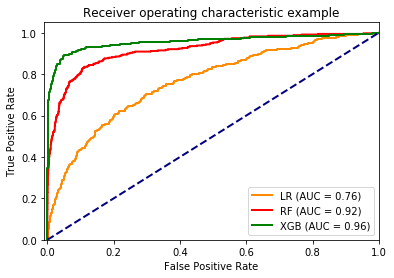

In [9]:
plt.figure()
lw = 2
plt.plot(LR_fpr, LR_tpr, color='darkorange',
         lw=lw, label='LR (AUC = %0.2f)' % LR_roc_auc)
plt.plot(RF_fpr, RF_tpr, color='red',
         lw=lw, label='RF (AUC = %0.2f)' % RF_roc_auc)
plt.plot(XG_fpr, XG_tpr, color='green',
         lw=lw, label='XGB (AUC = %0.2f)' % XG_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()